## Example of HomoSplice application to FGFR orthogroup

### Importing modules

In [14]:
from Bio import SeqIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import subprocess
import os
import pickle

import homosplice as hs
import importlib
importlib.reload(hs)

import warnings
warnings.simplefilter('ignore')

### Downloading genome sequences and annotations from databases

In [2]:
names = ['human','mouse','chick']

species = ['homo_sapiens',
           'mus_musculus',
           'gallus_gallus']

gtfs = ['Homo_sapiens.GRCh38.115.gtf.gz',
        'Mus_musculus.GRCm39.115.gtf.gz',
        'Gallus_gallus.bGalGal1.mat.broiler.GRCg7b.115.gtf.gz']

seqs = ['Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz',
        'Mus_musculus.GRCm39.dna.primary_assembly.fa.gz',
        'Gallus_gallus.bGalGal1.mat.broiler.GRCg7b.dna.toplevel.fa.gz']

gtfdict = dict()
fastadict = dict()

!mkdir genome_data\gtfs
!mkdir genome_data\fasta
for name,spec,gtf,seq in zip(names,species,gtfs,seqs):
    gtfpath = f'https://ftp.ensembl.org/pub/release-115/gtf/{spec}/{gtf}'
    fastapath = f'https://ftp.ensembl.org/pub/release-115/fasta/{spec}/dna/{seq}'

    gtfloc = fr"genome_data\gtfs\{os.path.basename(gtfpath)}"
    gtfdict[name] = gtfloc
    cmd = f'curl --ssl-no-revoke -o {gtfloc} {gtfpath}'
    if not os.path.exists(gtfloc):
        !{cmd}

    fastaloc = fr"genome_data\fasta\{os.path.basename(fastapath)}"
    fastadict[name] = fastaloc
    cmd = f'curl --ssl-no-revoke -o {fastaloc} {fastapath}'
    if not os.path.exists(fastaloc):
        !{cmd}
    print(name)

A subdirectory or file genome_data\gtfs already exists.


human
mouse
chick


A subdirectory or file genome_data\fasta already exists.


### Loading genome sequences and annotations to RAM

Genomes may be either loaded from fasta files or provided by user as a dict \<name\>:\<genome\>,<br>where genome is a dict \<chromname\>:\<Bio.Seq.Seq\>.

Annotations are loaded from gtf files with gtfparse library.

In both cases you may save genomes and gtf objects in a pickle file for fast loading

In [3]:
%%time
import gzip
gtfloc = 'genome_data/GTFS.pkl'
genomeloc = 'genome_data/GENOMES.pkl'

if os.path.exists(gtfloc):
    print('Read annotations from pickle file')
    with open(gtfloc,'rb') as file:
        hs.Sequence.GTFS = pickle.load(file)
else:
    print('Read annotations from GTF files (may take a lot of time)')
    for name,gtf in gtfdict.items():
        hs.Sequence.add_gtf(name=name,mask=gtf,override=True,use_gtfparse=False)
        print(name)
    with open(gtfloc,'wb') as file:
        print('Saving annotations to pickle for fast loading')
        pickle.dump(hs.Sequence.GTFS,file)

if os.path.exists(genomeloc):
    print('Read genomes from pickle file')
    with open(genomeloc,'rb') as file:
        hs.Sequence.GENOMES = pickle.load(file)
else:
    print('Read genomes from fasta (may take some time)')
    for name,genome in fastadict.items():
        with gzip.open(genome, "rt") as file:
            obj = SeqIO.to_dict(SeqIO.parse(file, "fasta"))
            obj = {key:val.seq for key,val in obj.items()}
            hs.Sequence.add_genome(name=name,obj = obj,override=True)
            print(name)
    with open(genomeloc,'wb') as file:
        print('Saving genomes to pickle for fast loading')
        pickle.dump(hs.Sequence.GENOMES,file)

Read annotations from GTF files (may take a lot of time)
human
mouse
chick
Saving annotations to pickle for fast loading
Read genomes from pickle file
Wall time: 11min 2s


#### Creating family object from homologous sequences

We will work with FGFR genes which are present in four copies in three analyzed genomes

In [4]:
hs.Sequence.GTFS['human'].chrn.iloc[0]

'1'

In [5]:
%%time
hgenes = [f'FGFR{i}' for i in range(1,5)]
mgenes = [f'Fgfr{i}' for i in range(1,5)]
cgenes = ['FGFR1', 'FGFR2', 'FGFR3', 'FGFRL1']
fam = hs.Family()
for hgene,mgene,cgene in zip(hgenes,mgenes,cgenes):
    fam.add_from_gtf(hgene,name='human_'+hgene)
    fam.add_from_gtf(mgene,name='mouse_'+mgene,gtf='mouse',genome='mouse')
    fam.add_from_gtf(cgene,name='chick_'+cgene,gtf='chick',genome='chick')

Wall time: 39.1 s


Users should specify a shell command for protein MSA. It should take sequences in fasta format from stdin and output MSA in fasta fromat to stdout

In [6]:
src = r'"C:\Program Files (x86)\clustal-omega-1.2.2-win64\clustalo.exe"'
cmd = f'{src} -i - --outfmt fa --wrap 1000000'

In [7]:
%%time
%time fam.align(cmd=cmd)  #align protein sequences
%time fam.get_scores() #calculate MSA columns scores (BLOSUM62 is default)
%time fam.msa2bordernum() #annotate each alignment position with exon number

Wall time: 1.29 s
Wall time: 777 ms
Wall time: 69.2 ms
Wall time: 2.14 s


#### Determining groups of homologous exons and introns and searching missing exons

In [8]:
import os
import subprocess
wd = './family_output/'
famname = 'FGFR1'
newhom,ihom,blastres = None,None,None

#partition exons into groups of homology
#partition introns into groups of homology based on exon grouping
m,ehom,ihom= fam.candidate_missing_exons() 
newhom = ehom

wd = wd+famname+'/'
if not os.path.exists(wd):
    subprocess.run(f'mkdir -p "{wd}"',shell=True)


#use blast to search for missing exons in introns of the corresponding homologous group
#Users need to specify /path/to/blast/directory/
if m is not None:
    res = m.apply(lambda x: hs.search_missing(x,wd=wd,famname=famname,evalue=1,windows=True,
                                              blastpath = r"C:\Program Files\NCBI\blast-2.17.0+\bin\\"),1)
    
    resdf = []
    for ind,df in res.items():
        df['ind'] = ind
        resdf.append(df)
    resdf = pd.concat(resdf)
    if len(resdf)>0:
        resdf['sseqid2'] = resdf.sseqid.str[:-2]
        resdf = resdf.drop_duplicates('sseqid2',keep='first').drop('sseqid2',1)
        resdf['homogroup'] = resdf.ind.map(m.homogroup)
        
        new = pd.DataFrame(resdf.apply(hs.blast2genome,1).tolist(),
                           columns=['seqname', 'exon_group', 'chrn', 
                                    'strand',  'start', 'end', 'homogroup', 'alone'])
        
        blastres = resdf[['pident', 'length', 'mismatch', 'gapopen', 
                          'evalue', 'bitscore', 'qseq', 'sseq']].set_index(new.index)
        blastres = pd.concat([new[['seqname','chrn','start','end','strand','homogroup']],blastres],1)

        inter = []
        for seq in new.seqname.unique():
            df = fam.dict[seq].borders.copy()
            df['seqname'] = seq
            inter.append(df)
        inter = pd.concat(inter)
        
        inter = inter.merge(new.drop('exon_group',1).reset_index())
        cond = np.maximum(inter.istart,inter.start)<=np.minimum(inter.iend,inter.end)
        bad = inter[cond]['index'].tolist()
        new = new.loc[new.index.difference(bad)]
        blastres = blastres.loc[new.index]

        newhom = pd.concat([ehom,new]).sort_values(['homogroup','seqname','exon_group'])

        dfs = [m,newhom,ihom,blastres]
        names = ['blast_searches.tsv','exon_homology.tsv','intron_homology.tsv','blast_hits.tsv']
        for df,name in zip(dfs,names):
            if df is None:
                with open(wd+name,'w'): pass
            else:
                df.to_csv(wd+name,sep='\t',index=False)
        with open(wd+'family.pkl','wb') as file:
            pickle.dump(fam,file)

### Visualizing  the results

In [9]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('tab10')
newhom['color'] = (newhom.homogroup%10).apply(cmap)
newhom.loc[newhom.alone==1,'color'] = 'black'
coloring = newhom.set_index(['seqname','exon_group']).color.to_dict()
newhom.drop('color',axis=1,inplace=True)

#### Prepare exon layout by tuning intron lengths with force-directed algorythm

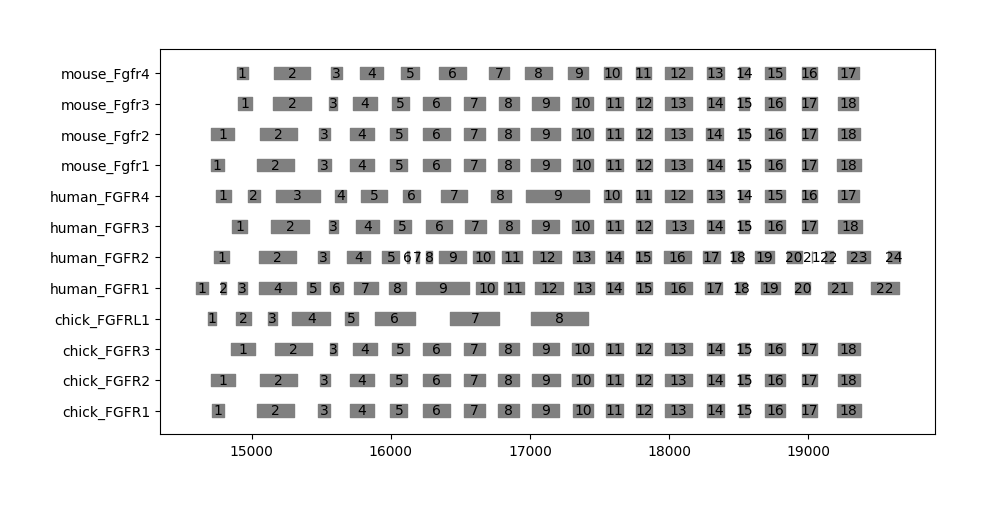

In [10]:
#In case of poor performance, try to increase iterations and/or decrease t
#Ilength is a mean desired intron length
G = fam.to_graph(ilength=200,pairwise=True)
G.FD(iterations=900,t=5)
f = G.plot()

#### Color exons by the group of homology, plot blast hits of missing exons in red

In human genes transcript regions belonging to MANE-Select isoform are highlighted by blue bar

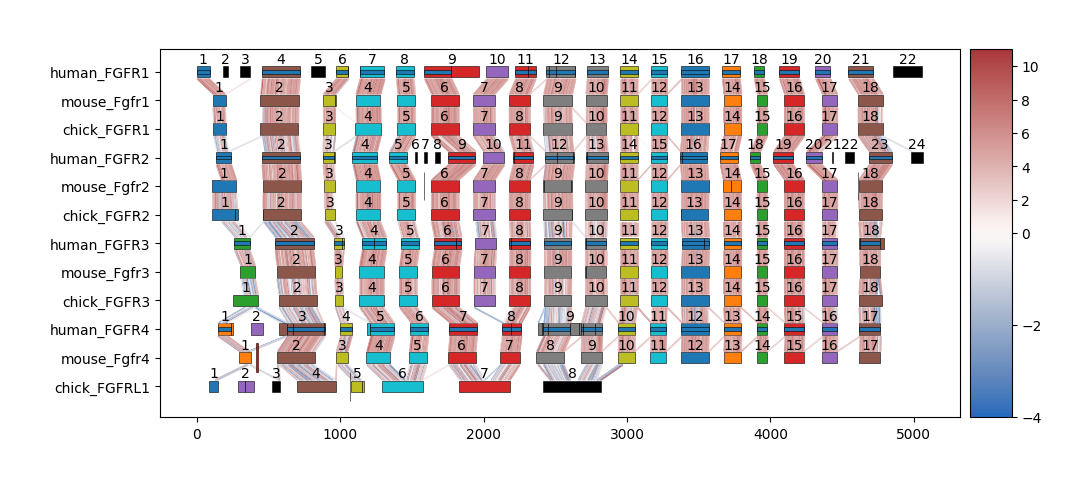

In [13]:
f,G = fam.draw_msa(G=G,highlight=['mane'],coloring=coloring,alpha=1,colorthr=-np.inf)
if blastres is not None:
    order = {i._text:i._y for i in f.axes[0].get_yticklabels()}
    new = newhom[newhom.exon_group==-1]
    starts = new[['seqname','start']].apply(tuple,1).tolist()
    ends = new[['seqname','end']].apply(tuple,1).tolist()
    starts = hs.convert_coords(starts,fam=fam,G=G)
    ends = hs.convert_coords(ends,fam=fam,G=G)
    ys = new.seqname.map(order)
    ax = f.axes[0]
    width = 0.5
    for start,end,y in zip(starts,ends,ys):
        ax.fill_between([start,end],y-width,y+width,color='red',alpha=1,edgecolor='black',
                        lw=0.4,zorder=20)

#### Zoom to any desired region of MSA

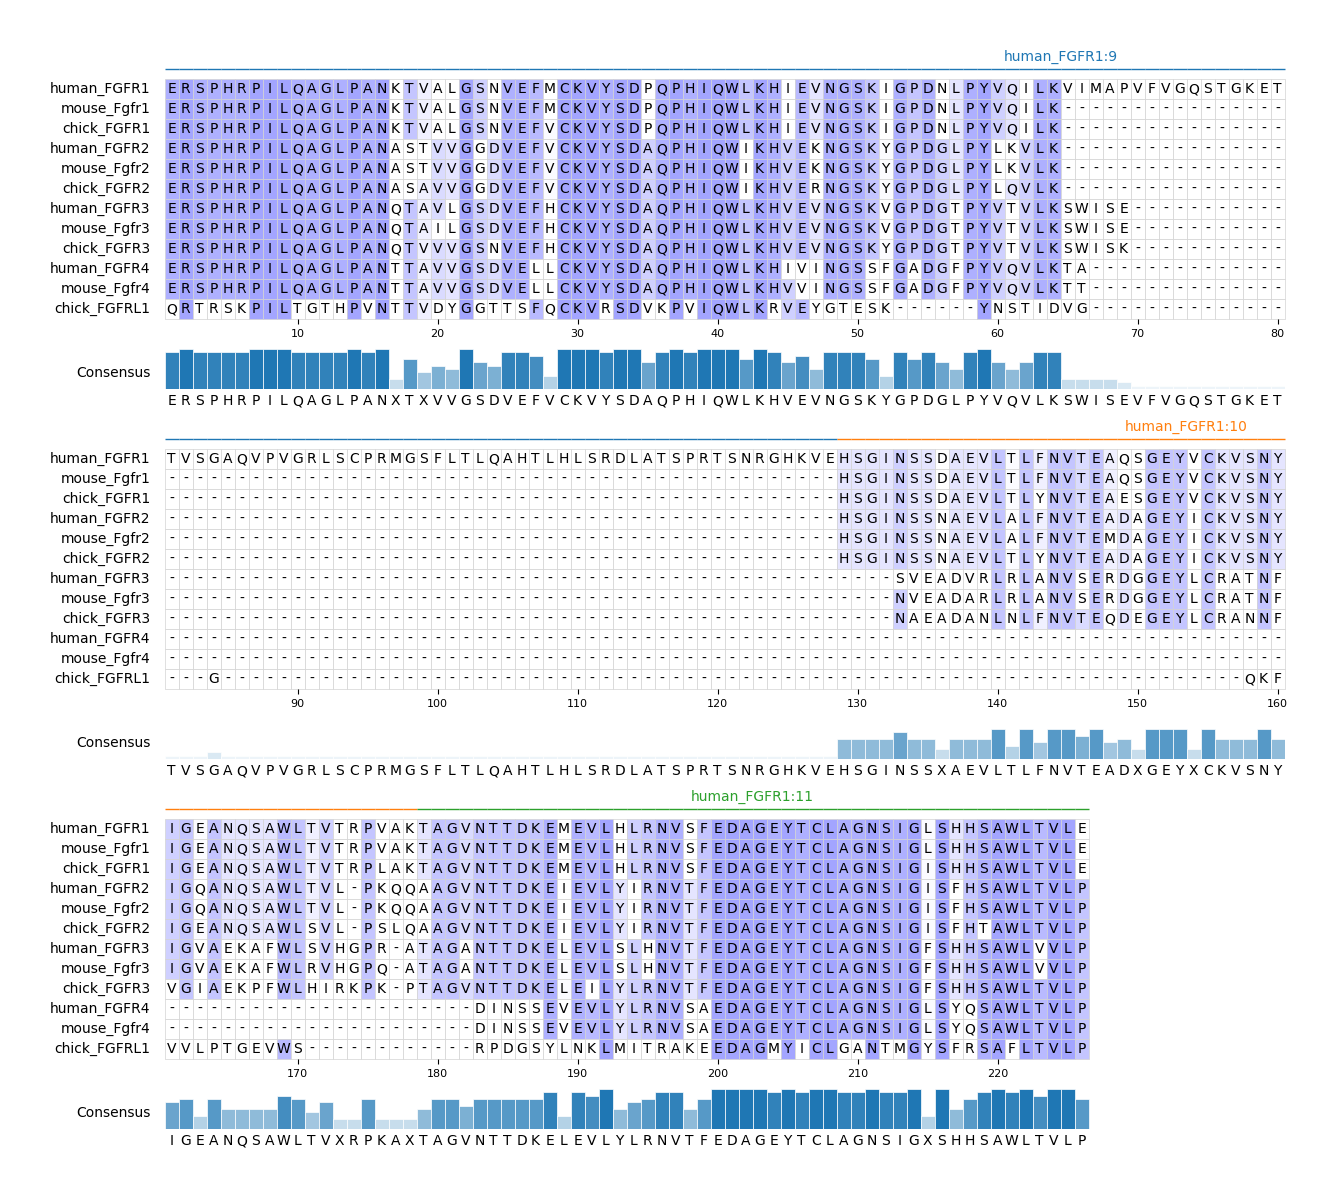

In [12]:
f,mv = fam.msaviz(ind={'human_FGFR1':[9,10,11]})